In [135]:
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

In [136]:
#TODO connect neurons into ANN

In [137]:
class Neuron:
    def __init__(self, af_type, weights=np.array([])):
        self.af_type = af_type
        self.weights = weights

    def activate(self, input):
        return self._activation_function(np.dot(input, self.weights))

    def _activation_function(self, a):
        if self.af_type == 'sigmoid':
            return 1/(1+np.exp(-a))
        elif self.af_type == 'relu':
            return max(0,a)
        
    def visualise(self, lab_input, lab_output, dim1=0, dim2=1, setpoint=np.array([]), toggle3d=False, n=100):          
        xs = np.linspace(0, 1, n)
        
        if np.shape(self.weights) == 1:
            a = np.empty(n)
            a = [self.activate(x) for x in xs]

            fig, ax = plt.subplots(1, 1, figsize=(6, 6))

            ax.plot(xs, a, cmap=cm.PiYG)
            ax.scatter(lab_input, lab_output, c=lab_output, cmap=cm.PiYG)
        else:
            if setpoint.size == 0 and np.shape(lab_input)[1] > 2:
                setpoint = 0.5*np.ones(np.shape(lab_input)[1]-2)

            aa = np.empty((n, n))
            for i, x1 in enumerate(xs):
                for j, x2 in enumerate(xs):
                    if setpoint.size > 0:
                        ip = setpoint
                        ip = np.insert(ip, [dim1, dim2], [x1, x2])
                    else:
                        ip = [x1, x2]
                    aa[i,j] = self.activate(ip)

            xx1, xx2 = np.meshgrid(xs, xs)
            
            if toggle3d:
                fig = plt.figure(figsize=(6,6))
                ax = fig.add_subplot(111, projection='3d')

                ax.plot_surface(xx1, xx2, aa, cmap=cm.PiYG)
                ax.scatter(lab_input[...,dim1].ravel(), lab_input[...,dim2].ravel(), lab_output, c=lab_output, edgecolors='k', cmap=cm.PiYG)
            else:
                fig, ax = plt.subplots(1, 1, figsize=(6, 6))

                ax.contourf(xx1, xx2, aa, 25, cmap=cm.PiYG)
                ax.scatter(lab_input[...,dim1].ravel(), lab_input[...,dim2].ravel(), c=lab_output, edgecolors='k', cmap=cm.PiYG)

        plt.show()

        return fig, ax

In [138]:
class NeuralNetwork:
    def __init__(self, structure, input_size, af_type):
        self.structure = structure
        self.input_size = input_size
        self.af_type = af_type

        self._create()
    
    def _create(self): 
        self.network = []   
        for i, layer_size in enumerate(self.structure):
            layer = [Neuron(self.af_type) for _ in range(0, layer_size)]

            weights_size = self.input_size if i == 0 else self.structure[i-1]
            for i, _ in enumerate(layer):
                layer[i].weights = np.empty(weights_size+1)

            self.network.append(layer)

    def activate(self, inputs):
        network_activity = []
        for i, layer in enumerate(self.network):
            layer_activity = [neuron.activate(inputs) for neuron in layer] if i == 0 else [neuron.activate(network_activity[-1]) for neuron in layer]
            network_activity.append(layer_activity)

        return network_activity[-1]

nn = NeuralNetwork([3, 1], 2, 'relu')
print(nn.network)

[[<__main__.Neuron object at 0x0000028C0DEBBA90>, <__main__.Neuron object at 0x0000028C0DEBBAC0>, <__main__.Neuron object at 0x0000028C0DEBB9A0>], [<__main__.Neuron object at 0x0000028C0DEBB400>]]


In [139]:
class Training:
    def __init__(self, l_inputs, l_outputs, training_type):
        self.training_type = training_type
        self.l_inputs = l_inputs
        self.l_outputs = l_outputs
        self.succeeded = True
    
    def train(self, neuron_tt, step_size, max_steps, w_decay=0.01):
        N = np.shape(self.l_inputs)[0]
        N_params = np.shape(self.l_inputs)[1]
        
        weights = np.random.rand(N_params)
        dLoss = np.ones(N_params)
        MSE = 1
        steps = 0

        for steps in range(0, max_steps):
            neuron_tt.weights = weights

            outputs = np.array([])
            for l_input in self.l_inputs:
                output = neuron_tt.activate(l_input)
                outputs = np.append(outputs, output)

            dLoss = np.array([])
            for i, l_input_col in enumerate(self.l_inputs.T):
                if self.training_type == 'mlf':
                    dLoss = np.append(dLoss, -np.sum(np.multiply((self.l_outputs - outputs), l_input_col)))
                elif self.training_type == 'rmlf':
                    dLoss = np.append(dLoss, -np.sum(np.multiply((self.l_outputs - outputs),l_input_col) + w_decay*neuron_tt.weights[i]))

            weights -= step_size*dLoss
            
            MSE = np.sum(np.array([(output - expected_output)**2 for output, expected_output in zip(outputs, self.l_outputs)]))/np.shape(outputs)[0]
            if steps == 0 or steps % 5000 == 0: print(f'{steps} steps, MSE = {MSE}')

            steps += 1
        
        print(f'Training Completed with final MSE = {MSE} and dLoss = {dLoss}')

        return weights

In [140]:
tx = np.array([[0.1, 0.1],[0.2, 0.2],[0.3, 0.3],[0.4, 0.4], [0.6, 0.6], [0.7, 0.7],[0.8, 0.8],[0.9, 0.9]])
ty = np.array([0,0,0,0,1,1,1,1])

0 steps, MSE = 0.20755272971360184
5000 steps, MSE = 0.20737725405805485
10000 steps, MSE = 0.2072332654049232
15000 steps, MSE = 0.2071165805820364
20000 steps, MSE = 0.20702355427554392
25000 steps, MSE = 0.2069510077709794
30000 steps, MSE = 0.20689616753524187
35000 steps, MSE = 0.20685661223971352
40000 steps, MSE = 0.20683022702355208
45000 steps, MSE = 0.2068151639686347
50000 steps, MSE = 0.20680980790633924
55000 steps, MSE = 0.2068127468040566
60000 steps, MSE = 0.2068227460886647
65000 steps, MSE = 0.20683872635760012
70000 steps, MSE = 0.20685974400784313
75000 steps, MSE = 0.20688497438103376
80000 steps, MSE = 0.20691369708078214
85000 steps, MSE = 0.20694528316749963
90000 steps, MSE = 0.20697918397804252
95000 steps, MSE = 0.2070149213532244
Training Completed with final MSE = 0.20705207153813807 and dLoss = [-0.09451689 -0.09451689]


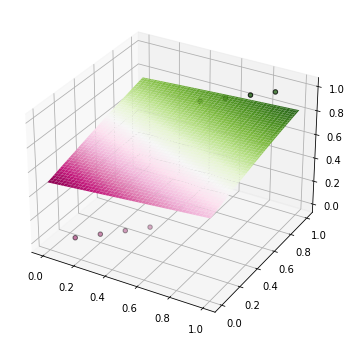

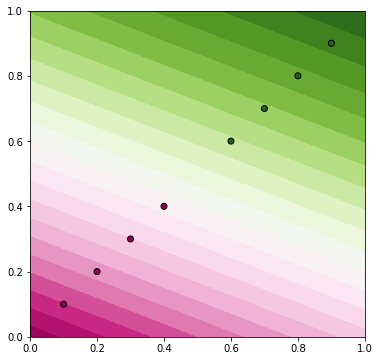

In [141]:
ntt =  Neuron('sigmoid')
tn = Training(tx, ty, 'mlf')
_ = tn.train(ntt, 0.00001, 100000)
_, _ = ntt.visualise(tx, ty, toggle3d=True)
_, _ = ntt.visualise(tx, ty)

0 steps, MSE = 0.21549528956000694
5000 steps, MSE = 0.21044729323425163
10000 steps, MSE = 0.21077027102597312
15000 steps, MSE = 0.21077845809288176
20000 steps, MSE = 0.2107786630024135
25000 steps, MSE = 0.21077866812939788
30000 steps, MSE = 0.21077866825767785
35000 steps, MSE = 0.21077866826088754
Training Completed with final MSE = 0.2107786682609677 and dLoss = [-0.54445705  0.54445705]


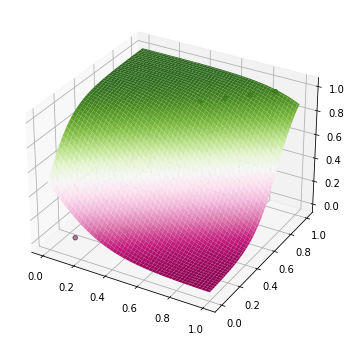

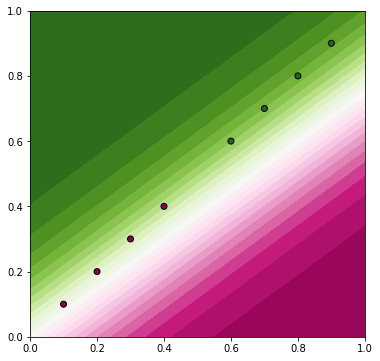

In [142]:
ntt2 = Neuron('sigmoid')
tn2 = Training(tx, ty, 'rmlf')
_ = tn2.train(ntt2, 0.001, 40000, 0.01)
_, _ = ntt2.visualise(tx, ty, toggle3d=True)
_, _ = ntt2.visualise(tx, ty)